# Colors prediction and clusters visualization
### Predict embeddings with trained tf-lite model and visualize embedding space in lower 3d dimension 

### 1. Import all necessary modules

In [1]:
import numpy as np
import tensorflow as tf
import joblib
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from umap import UMAP
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d
%matplotlib inline

### 2. Load dataset

In [27]:
colors = joblib.load('dataset.dict')

### 3. Define helper class to use tf-lite model as usual keras models

In [58]:
class WrapperTFLite:
    '''Class implementing a wrapper for tf-lite models so it can be used with 
    usual keras.Model's methods.

    Attributes:
        interpreter (tensorflow.lite.Interpreter obj): interpreter for the model.
        input_details (dict): properties about an input image, including it's shape and dtype.
        output_details (dict): properties about an output, including it's shape and dtype.
        
    '''
    __slots__ = ['interpreter', 'input_details', 'output_details']
    def __init__(self, path):
        '''Constructor of tf-lite wrapper class. In constructor you have to define a path
        to the tf lite model

            Args:
                path (str): path to a tensorflow lite model.

        '''
        self.interpreter = tf.lite.Interpreter(path)
        self.interpreter.allocate_tensors()
        # obtaining the input-output shapes and types
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, data):
        '''Convinient method to use trained model over all data 
        (tensorflow lite models can predict only one image per time).

            Args:
                data (numpy.ndarray): array as input for the model.

            Returns:
                predictions (numpy.ndarray): model's output array.

        '''
        prediction = []
        # use tqdm for progress bar
        for i in tqdm(range(data.shape[0])):
            # resize input image so it corresponds to the input shape
            img = np.array(Image.fromarray(data[i]).resize(self.input_details[0]['shape'][1:-1], Image.BICUBIC))
            self.interpreter.set_tensor(self.input_details[0]['index'], img.reshape(1, *img.shape)[:,:,:,::-1])
            # running inference
            self.interpreter.invoke()
            # get result and append to prediction list
            prediction.extend(self.interpreter.get_tensor(self.output_details[0]['index']))
        return np.array(prediction)

# load trained tf lite model
network_tflite = WrapperTFLite('colors_mobilenet.tflite')

In [33]:
# check input dimensions for the image
network_tflite.input_details[0]['shape']

array([  1, 128, 128,   3])

### 4. Predict embeddings for each image, calculate cluster's centers and standart deviations of clusters

In [59]:
preds = []
means = []
stds = []
for i in colors.keys():
    preds.append(network_tflite.predict(colors[i]))
    means.append(preds[-1].mean(axis=0))
    stds.append(preds[-1].std(axis=0))

d:\captcha\synvae\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


### 5. Train a dimensionality reduction model on acquired embeddings and transform them to lower three-dimensional space

In [60]:
transformer = UMAP(n_components=3, random_state=69).fit(np.concatenate(preds, axis=0))

In [61]:
three_d_preds = []
for i in colors.keys():
    three_d_preds.append(transformer.transform(preds[i]))

### 6. Visualize and animate 3D space of embeddings

d:\captcha\synvae\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


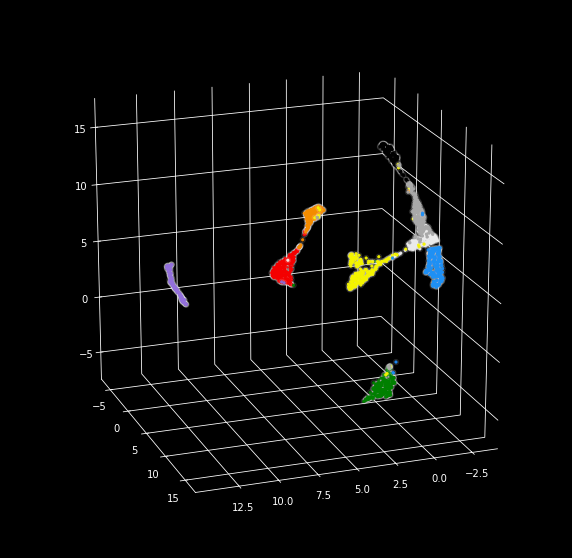

In [157]:
plt.style.use('dark_background')
# set canvas size to 10x10 inches
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# disable planes colors
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# progress bar for animation rendering
pbar = tqdm(range(360))


def init():
    # redraw the data with low alpha and slighty increased linewidth:
    n_shades = 10
    diff_linewidth = 0.35
    alpha_value = 0.9 / n_shades
    # colors for color clusters
    colors = ['black', 'dodgerblue', 'green', 'darkgrey', 'darkorange', 
              'mediumpurple', 'red', 'whitesmoke', 'yellow']
    # at first add some white halo so all cluster will be visible on black background
    for i, c in enumerate(['whitesmoke']*len(list(three_d_preds.keys())):
        ax.scatter3D(three_d_preds[i][:, 0], three_d_preds[i][:, 1], 
                     three_d_preds[i][:, 2], alpha=0.05, 
                     c=[c]*three_d_preds[i].shape[0], s=30)
    # visualize clusters with corresponding colors 
    for n in range(1, n_shades+1):
        for i, c in enumerate():
            ax.scatter3D(three_d_preds[i][:, 0], three_d_preds[i][:, 1], 
                         three_d_preds[i][:, 2], alpha=alpha_value, 
                         c=[c]*three_d_preds[i].shape[0], s=2+(diff_linewidth*n))
    return fig,

def animate(i):
    # progress update and rotate 3d space along azimut
    pbar.update(1)
    ax.view_init(elev=20., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('color_projection.gif', writer='imagemagick')
ax.view_init(elev=20., azim=70)

As we can see from the above image embeddings are visualy separable. Similar colors appear to locating near each other  

### 7. Replace embeddings with it's centers with small noisy fluctuations

In [174]:
center_preds = []
for i, (mean, std) in enumerate(zip(means, stds)):
    center_preds.append(np.random.multivariate_normal(mean, np.eye(std.shape[0])*std/1e1, size=preds[i].shape[0]))

### 8. Save results to the disk

In [176]:
joblib.dump(center_preds, 'embed.gz', 3, 4)

['embed.gz']